In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def make_tiles(num_tiles):
    # 8, 32, 72, 128, 200, ... 800, ...
    
    assert np.sqrt(num_tiles / 2) % 2 == 0, 'must be able to be divided evenly into two squares with even side lengths'
    tiles = np.arange(0, num_tiles)
    tiles += 1  # add one to make no non-zero indices (optional)

    # arrange into rectangle that is twice as long as tall
    vertical_dimension = np.sqrt(num_tiles / 2)
    horizontal_dimension = num_tiles / vertical_dimension
    dimensions = (int(vertical_dimension), int(horizontal_dimension))
    tiles = tiles.reshape(dimensions)
    
    return tiles

In [3]:
def transform(tiles_to_transform, transformation_matrix):
    plot = False
    transformed = np.zeros(tiles_to_transform.shape)
    
    if plot:
        plt.figure()
        plt.grid()
    
    for i, row in enumerate(tiles_to_transform):
        for j, tile_value in enumerate(row):
            if tile_value == 0:
                continue
                
            input_coords = np.array([i, j, 1])
            i_out, j_out, _ = transformation_matrix @ input_coords
            i_out, j_out = (int(i_out), int(j_out))
            transformed[i_out, j_out] = tile_value

            if plot:
                print(f'Transformed: ({i}, {j}) -> ({i_out}, {j_out}): {tile_value}')
                plt.plot([j, j_out], [-i, -i_out], 'ko--')
                plt.plot(j_out, -i_out, 'r.')
    
    return transformed

In [4]:
def kevin_flip(tiles):
    # tiles that don't move (checkerboard across whole array)
    static_mask = np.ones(tiles.shape)
    static_mask[1::2,::2] = 0
    static_mask[::2,1::2] = 0
    static_tiles = static_mask * tiles

    # create an inverse mask to apply on left & right tiles
    inverse_static_mask = np.zeros(tiles.shape)
    inverse_static_mask[static_mask==0] = static_mask[static_mask==1]

    # the left tiles (that will be translated right)
    left_tiles = np.zeros(tiles.shape)
    left_tiles[:,:tiles.shape[0]] = tiles[:,:tiles.shape[0]]
    left_tiles *= inverse_static_mask

    # the right tiles (that will be rotated and translated left)
    right_tiles = np.zeros(tiles.shape)
    right_tiles[:,tiles.shape[0]:] = tiles[:,tiles.shape[0]:]
    right_tiles *= inverse_static_mask
    
    # translation matrix for left tiles
    shift_to_the_right = np.identity(3)
    shift_to_the_right[1][2] = tiles.shape[1] // 2
    left_tiles_transformed = transform(tiles_to_transform=left_tiles, transformation_matrix=shift_to_the_right)

    # transformation matrices for right tiles
    rotate_180 = np.array([[-1, 0, 0], [0, -1, 0], [0, 0, 1]])
    shift = np.identity(3)
    shift[1][2] = tiles.shape[1] - 1
    shift[0][2] = tiles.shape[0] - 1

    # transformation = rotate_180 @ shift
    transformation = shift @ rotate_180

    right_tiles_transformed = transform(tiles_to_transform=right_tiles, transformation_matrix=transformation)
    
    # put it all together
    return static_tiles + left_tiles_transformed + right_tiles_transformed

In [6]:
from typing import Dict


def find_neighbors(tile_array) -> Dict:
    neighbors = {}
    for row_idx, row in enumerate(tile_array):
        for col_idx, value in enumerate(row):
            neighbor_values = []
            
            # check if it's on any of the borders
            down_ok = True if row_idx < tile_array.shape[0] - 1 else False
            up_ok = True if row_idx != 0 else False
            right_ok = True if col_idx < tile_array.shape[1] - 1 else False
            left_ok = True if col_idx != 0 else False

            # directly adjacent tiles
            if down_ok:
                neighbor_value = tile_array[row_idx + 1][col_idx]
                neighbor_values.append(neighbor_value)
            
            if up_ok:
                neighbor_value = tile_array[row_idx - 1][col_idx]
                neighbor_values.append(neighbor_value)

            if right_ok:
                neighbor_value = tile_array[row_idx][col_idx + 1]
                neighbor_values.append(neighbor_value)
                
            if left_ok:
                neighbor_value = tile_array[row_idx][col_idx - 1]
                neighbor_values.append(neighbor_value)
            
            # corner tiles
            if right_ok and up_ok:
                neighbor_value = tile_array[row_idx - 1][col_idx + 1]
                neighbor_values.append(neighbor_value)

            if left_ok and up_ok:
                neighbor_value = tile_array[row_idx - 1][col_idx -1]
                neighbor_values.append(neighbor_value)
                
            if left_ok and down_ok:
                neighbor_value = tile_array[row_idx + 1][col_idx -1]
                neighbor_values.append(neighbor_value)
            
            if right_ok and down_ok:
                neighbor_value = tile_array[row_idx + 1][col_idx + 1]
                neighbor_values.append(neighbor_value)
            
            neighbors[value] = neighbor_values
    
    return neighbors


In [26]:
def compare_neighbors(first_array, second_array, print_results = False):
    # print(tiles)
    # print()
    # print(final)
    # print()

    first_neighbors = find_neighbors(tile_array = first_array)
    final_neighbors = find_neighbors(tile_array = second_array)

    num_kept_neighbors = 0
    for tile, neighbors in final_neighbors.items():
        kept_neighbors = set(neighbors) & set(first_neighbors[tile])
        num_kept_neighbors += len(kept_neighbors)
    #     print(f'{int(tile)}: {kept_neighbors}')

    num_first_neighbors = 0
    for neighbors in first_neighbors.values():
        num_first_neighbors += len(neighbors)
    
    ratio = num_kept_neighbors / num_first_neighbors * 100
        
    if print_results:
        print(f'Tiles: {np.prod(first_array.size)} ({num_first_neighbors} total neighbors)')
        print(f'Number of kept neighors: {num_kept_neighbors} ({ratio:.2f}%)')
    
    return ratio

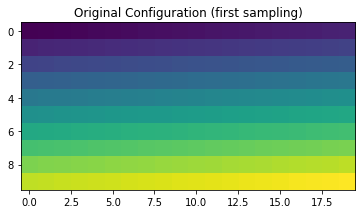

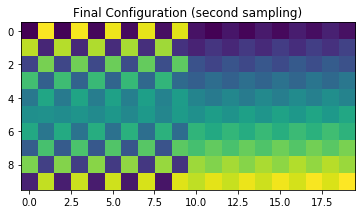

In [34]:
tiles = make_tiles(num_tiles=200)
final = kevin_flip(tiles)

# plotting
plt.figure()
plt.title('Original Configuration (first sampling)')
plt.imshow(tiles)

plt.figure()
plt.title('Final Configuration (second sampling)')
plt.imshow(final)

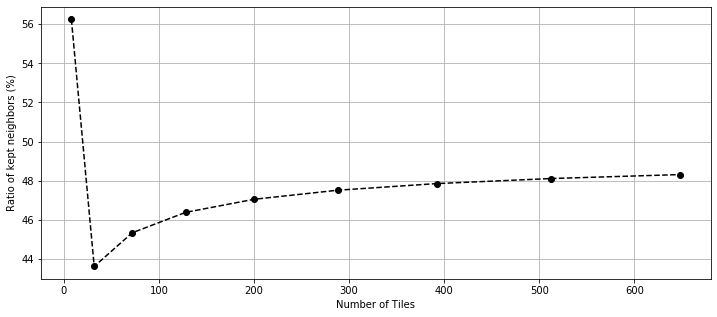

In [44]:
num_tiles_list = []
ratio_list = []
for row in range(2, 20, 2):
    num_tiles = 2 * row ** 2
    tiles = make_tiles(num_tiles=num_tiles)
    final = kevin_flip(tiles)
    ratio = compare_neighbors(tiles, final)
    
#     print(f'tiles: {num_tiles}; ratio: {ratio:.2f}')
    num_tiles_list.append(num_tiles)
    ratio_list.append(ratio)

plt.figure(figsize=(12, 5))
plt.grid()
plt.xlabel('Number of Tiles')
plt.ylabel('Ratio of kept neighbors (%)')
plt.plot(num_tiles_list, ratio_list, 'ko--')